# Evaluatie 02: Tour-de-France

bron: [Tour de France](https://github.com/wjsutton/Tour-De-France)  
auteur: Will Sutton

## Stap 01: downloaden CSV-bestand

URL: [the_toughest_tour.csv](https://github.com/wjsutton/Tour-De-France/blob/master/data/the_toughest_tour.csv)

In [ ]:
url = 'https://raw.githubusercontent.com/wjsutton/Tour-De-France/refs/heads/master/data/the_toughest_tour.csv'
bestand = 'tour-de-france.csv'

from os.path import exists
from urllib.request import urlretrieve

if not exists(bestand):
    urlretrieve(url=url, filename=bestand) 

## Stap 02: database

In [4]:
import sqlite3
from traceback import print_exc

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    # -- tabel DEELNEMER
    dbSql = '''
        DROP TABLE IF EXISTS deelnemer
    '''
    dbCursor.execute(dbSql)

    dbSql = '''
        CREATE TABLE deelnemer(
            deelnemerID INTEGER PRIMARY KEY AUTOINCREMENT,
            naam TEXT
        )
    '''
    dbCursor.execute(dbSql)

    # -- tabel TOUR
    dbSql = '''
        DROP TABLE IF EXISTS tour
    '''
    dbCursor.execute(dbSql)

    dbSql = '''
        CREATE TABLE tour(
            tourID INTEGER PRIMARY KEY,
            gemiddelde_snelheid REAL DEFAULT 0,
            afstand INTEGER DEFAULT 0,
            hoogste_top INTEGER DEFAULT 0
        )
    '''
    dbCursor.execute(dbSql)

    # -- tabel winnaar
    dbSql = '''
        DROP TABLE IF EXISTS winnaar
    '''
    dbCursor.execute(dbSql)

    dbSql = '''
        CREATE TABLE winnaar(
            deelnemerID INTEGER NOT NULL,
            tourID INTEGER NOT NULL,
            PRIMARY KEY(deelnemerID, tourID),
            FOREIGN KEY(deelnemerID) REFERENCES deelnemer(deelnemerID),
            FOREIGN KEY(tourID) REFERENCES tour(tourID)
        )
    '''
    dbCursor.execute(dbSql)

    dbVerbinding.commit()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

## Stap 03: bevolken database

### 0301 Tabel 'deelnemer'

In [8]:
import sqlite3
from traceback import print_exc
import csv

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    deelnemers = set()

    dbSql = '''
        DELETE
        FROM deelnemer
    '''
    dbCursor.execute(dbSql)

    dbSql ='''
        UPDATE SQLITE_SEQUENCE SET seq=0 WHERE name='deelnemer'
    '''
    dbCursor.execute(dbSql)

    with open('tour-de-france.csv', 'rt', encoding='utf-8') as bestand:
        dta = csv.reader(bestand)
        next(dta)

        for lijn in dta:
            if lijn[1] == 'winners_avg_speed':
                tmp = lijn[4]
                deelnemer = tmp[:tmp.index(' won')]
                deelnemers.add((deelnemer,))

        dbSql = '''
            INSERT INTO deelnemer(naam)
            VALUES(?)
        '''
        dbCursor.executemany(dbSql, deelnemers)

        dbVerbinding.commit()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

### 0302 Tabel 'tour' en tabel 'winnaar'

In [9]:
import sqlite3
from traceback import print_exc
import csv

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    jaar = 0
    tour = []
    deelnemerID = 0

    # RESET TOUR
    dbSql = '''
        DELETE
        FROM tour
    '''
    dbCursor.execute(dbSql)

    dbSql = '''
        UPDATE SQLITE_SEQUENCE SET seq = 0 WHERE name = 'tour'
    '''
    dbCursor.execute(dbSql)

    # RESET WINNAAR
    dbSql = '''
        DELETE
        FROM winnaar
    '''
    dbCursor.execute(dbSql)

    dbSql = '''
        UPDATE SQLITE_SEQUENCE SET seq = 0 WHERE name = 'winnaar'
    '''
    dbCursor.execute(dbSql)

    # SELECTEER deelnemer
    dbSql = '''
        SELECT naam, deelnemerID
        FROM deelnemer
    '''
    dbDeelnemer = dict(dbCursor.execute(dbSql))

    dbSqlTour = '''
        INSERT INTO tour(tourID, gemiddelde_snelheid, afstand, hoogste_top)
        VALUES(?, ?, ?, ?)
    '''

    dbSqlWinnaar = '''
        INSERT INTO winnaar(deelnemerID, tourID)
        VALUES(?, ?)
    '''

    with open('tour-de-france.csv', 'rt', encoding='utf-8') as bestand:
        oCSV = csv.reader(bestand)
        next(bestand)

        for lijn in oCSV:
            if lijn[1] == 'winners_avg_speed':
                if jaar == 0:
                    pass
                elif jaar != int(lijn[0]):
                    dbCursor.execute(dbSqlTour, tour)
                    tourID = dbCursor.lastrowid
                    dbCursor.execute(dbSqlWinnaar, (deelnemerID, tourID))
                    tour = []
                    deelnemerID = 0

                jaar = int(lijn[0])
                snelheid = round(float(lijn[3]), 2)
                tmp = lijn[4]
                deelnemer = tmp[:tmp.index(' won')]
                deelnemerID = dbDeelnemer[deelnemer]                
                tour.append(jaar)
                tour.append(snelheid)
            elif lijn[1] == 'total_distance_in_km':
                afstand = int(lijn[3].split('.')[0])
                tour.append(afstand)
            elif lijn[1] == 'highest_elevation_in_m':
                hoogte = int(lijn[3])
                tour.append(hoogte)

    dbVerbinding.commit()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

## Stap 04: Verwerking

### 0401 4 of meer overwinnngen

Geef met behulp van een staafdiagram een overzicht van de deelnemers met 4 of meer

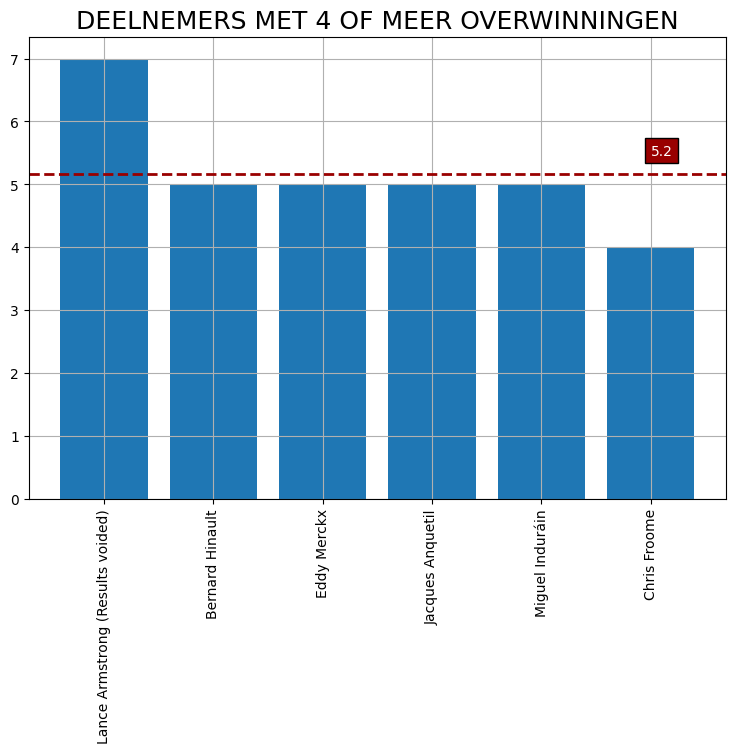

In [26]:
import sqlite3
from traceback import print_exc
from statistics import mean
import matplotlib.pyplot as plt

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    dbSql = '''
        SELECT COUNT(1) AS aantal, d.naam
        FROM tour t 
        JOIN winnaar w 
        ON w.tourID = t.tourID
        JOIN deelnemer d 
        ON d.deelnemerID = w.deelnemerID
        GROUP BY w.deelnemerID
        HAVING aantal > 3
        ORDER BY aantal DESC, naam ASC
    '''
    dbRslt = dbCursor.execute(dbSql).fetchall()

    deelnemers = []
    aantal = []
    for dbRij in dbRslt:
        aantal.append(dbRij[0])
        deelnemers.append(dbRij[1])

    plt.figure(figsize=(9,6))
    plt.grid(True)
    plt.bar(x=deelnemers, height=aantal, width=0.8)
    plt.xticks(rotation=90)

    plt.title('DEELNEMERS MET 4 OF MEER OVERWINNINGEN', fontdict={'size':18})

    gemiddelde = mean(aantal)
    plt.axhline(y=gemiddelde, color='#990000', linewidth=2, linestyle='--')
    plt.text(x = 5, y = gemiddelde + 0.3, s = f'{gemiddelde:0.1f}', color='white', bbox={'facecolor': '#990000'})

    plt.show()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

### 0402 Afstand en top

Stel per jaar de afstand en de hoogste top van de tour voor in een lijndiagram

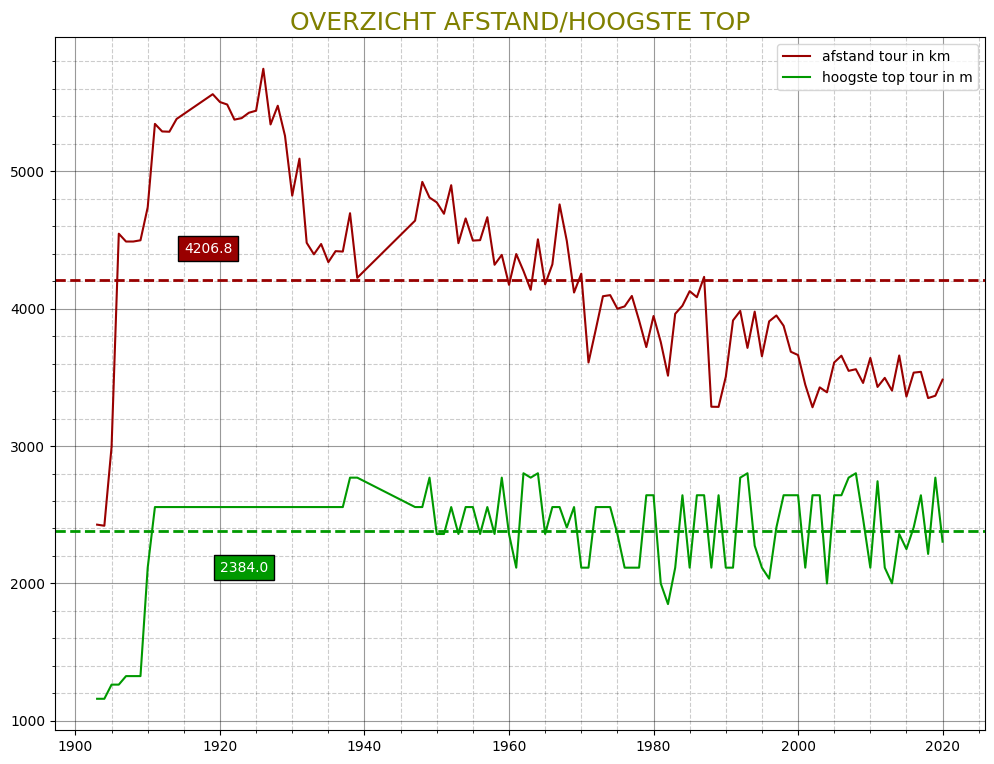

In [38]:
import sqlite3
from traceback import print_exc
import matplotlib.pyplot as plt
from statistics import mean

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    dbSql = '''
        SELECT tourID, afstand, hoogste_top
        FROM tour
        ORDER BY tourID
    '''
    dbRslt = dbCursor.execute(dbSql).fetchall()

    jaar = []
    afstand = []
    hoogte = []

    for dbRij in dbRslt:
        jaar.append(dbRij[0])
        afstand.append(dbRij[1])
        hoogte.append(dbRij[2])

    plt.figure(figsize=(12,9))
    plt.grid(True, linestyle='-', color='black', alpha=0.4, which='major')
    plt.grid(True, linestyle='--', color='black', alpha=0.2, which='minor')
    plt.minorticks_on()

    plt.plot(jaar, afstand, color='#990000', label='afstand tour in km')
    plt.plot(jaar, hoogte, color='#009900', label='hoogste top tour in m')

    plt.title('OVERZICHT AFSTAND/HOOGSTE TOP', fontdict={'size': 18, 'color': 'olive'})
    plt.legend()

    gemiddelde = mean(afstand)
    plt.axhline(y=gemiddelde, color='#990000', linewidth=2, linestyle='--')
    plt.text(x=1915, y=gemiddelde+200, s=f'{gemiddelde:0.1f}', color='white', bbox={'facecolor': '#990000'})

    gemiddelde = mean(hoogte)
    plt.axhline(y=gemiddelde, color='#009900', linewidth=2, linestyle='--')
    plt.text(x=1920, y=gemiddelde-300, s=f'{gemiddelde:0.1f}', color='white', bbox={'facecolor': '#009900'})

    plt.show()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

### 0403: Eddy Merckx

Geef een overzicht van de overwinningen van Eddy Merckx: jaar, gemiddelde snelheid, afstand en hoogste top

In [3]:
import sqlite3
from traceback import print_exc

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    dbSql = '''
        SELECT t.tourID, t.gemiddelde_snelheid, t.afstand, t.hoogste_top
        FROM tour t
        JOIN winnaar w
          ON t.tourID = w.tourID
        JOIN deelnemer d
          ON d.deelnemerID = w.deelnemerID
        WHERE d.naam = 'eddy merckx' COLLATE NOCASE
        ORDER BY t.tourID
    '''
    dbRslt = dbCursor.execute(dbSql).fetchall()

    print(f'{"OVERWINNINGEN EDDY MERCKX":^58}')
    print(f'{"jaar":<4} | {"gemiddelde snelheid (km/u)":>26} | {"afstand (km)":>12} | {"top (m)":>7}')
    print('-'*58)
    for dbRij in dbRslt:
        print(f'{dbRij[0]:<4} | {dbRij[1]:>26} | {dbRij[2]:>12} | {dbRij[3]:>7}')

except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

                OVERWINNINGEN EDDY MERCKX                 
jaar | gemiddelde snelheid (km/u) | afstand (km) | top (m)
----------------------------------------------------------
1969 |                      35.41 |         4117 |    2556
1970 |                      35.59 |         4254 |    2115
1971 |                      38.08 |         3608 |    2115
1972 |                      35.51 |         3846 |    2556
1974 |                      35.24 |         4098 |    2556


### 0404 De 10 langste tours

Geef een overzicht van de 10 langste tour-de-france parcours.   
Van elk parcour geef je de winnaar, het jaartal en de afstand

In [4]:
import sqlite3
from traceback import print_exc

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    dbSql = '''
        SELECT d.naam, t.tourID, t.afstand
        FROM tour t
        JOIN winnaar w
          ON t.tourID = w.tourID
        JOIN deelnemer d
          ON d.deelnemerID = w.deelnemerID
        ORDER BY afstand DESC
        LIMIT 0, 10
    '''
    dbRslt = dbCursor.execute(dbSql).fetchall()

    print(f'{"DE 10 LANGSTE PARCOURS":^42}')
    print(f'{"jaar":^4} | {"winnaaar":<20} | {"afstand (km)":^12}')
    print('-'*42)
    for dbRij in dbRslt:
        print(f'{dbRij[0]:^4} | {dbRij[1]:<20} | {dbRij[2]:^12}')
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()

          DE 10 LANGSTE PARCOURS          
jaar | winnaaar             | afstand (km)
------------------------------------------
Lucien Buysse | 1926                 |     5745    
Firmin Lambot | 1919                 |     5560    
Philippe Thys | 1920                 |     5503    
Léon Scieur | 1921                 |     5485    
Nicolas Frantz | 1928                 |     5476    
Ottavio Bottecchia | 1925                 |     5440    
Ottavio Bottecchia | 1924                 |     5425    
Henri Pélissier | 1923                 |     5386    
Philippe Thys | 1914                 |     5380    
Firmin Lambot | 1922                 |     5375    


### 0405 Top 5 totale afstand winnaars

Het gaat over de totale afstand die elke winnaar bij deelname aan de tour-de-france heeft afgelegd.   
Je geeft van elke deelnemer in de top 5 de naam, het aantal wedstrijden, de totale afstand en het gemiddelde van de gemiddelde snelheid.   
Stel het resultaat voor in een taartdiagram.

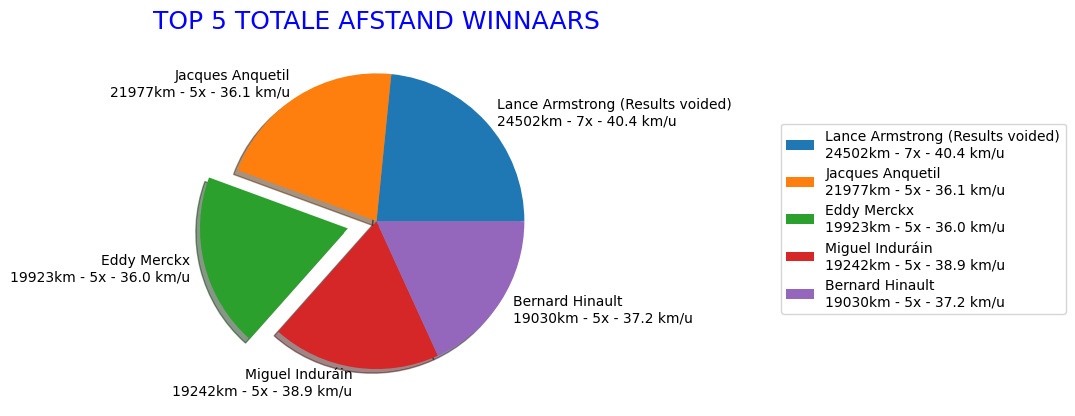

In [13]:
import sqlite3
from traceback import print_exc
import matplotlib.pyplot  as plt

dbVerbinding = sqlite3.connect('tourdefrance.sqlite3')
dbCursor = dbVerbinding.cursor()

try:
    dbSql = '''
        SELECT d.naam, COUNT(1) AS aantal, SUM(afstand) AS afstand, ROUND(AVG(t.gemiddelde_snelheid), 2)
        FROM tour t
        JOIN winnaar w
          ON t.tourID = w.tourID
        JOIN deelnemer d
          ON d.deelnemerID = w.deelnemerID
        GROUP BY w.deelnemerID
        ORDER BY afstand DESC, aantal DESC
        LIMIT 0, 5
    '''
    dbRslt = dbCursor.execute(dbSql).fetchall()

    deelnemer = []
    aantal = []
    afstand = []
    snelheid = []

    for dbRij in dbRslt:
        aantal.append(dbRij[1])
        afstand.append(dbRij[2])
        snelheid.append(dbRij[3])
        deelnemer.append(f'{dbRij[0]}\n{dbRij[2]}km - {dbRij[1]}x - {dbRij[3]:0.1f} km/u')

    plt.title('TOP 5 TOTALE AFSTAND WINNAARS', fontdict = {'size': 18, 'color': 'blue'})
    plt.pie(
        x = afstand,
        labels = deelnemer,
        shadow = True,
        textprops = {'fontsize': 10},
        explode = [0, 0, 0.2, 0, 0]
    )

    plt.legend(deelnemer, bbox_to_anchor=(1.6, 0.5), loc='center right', fontsize=10, 
               bbox_transform=plt.gcf().transFigure)
    
    plt.savefig('0405.png')
    plt.show()
except Exception as ex:
    print_exc()

if dbCursor: dbCursor.close()
if dbVerbinding: dbVerbinding.close()